In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error
from sklearn.model_selection import validation_curve
import optuna
from sklearn.metrics import r2_score

In [3]:
data=pd.read_csv(r"C:\Users\Avijit\Desktop\AgriAssure\AGRIYIELDPRO\PROCESSED_DATASET\yield5.csv")

In [4]:
x,y=data.iloc[:,:-1],data.iloc[:,-1:]
y1=np.reshape(y,shape=(-1))


In [5]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y1,train_size=0.8,random_state=32)

In [ ]:
params={'booster': 'dart',
 'lambda': 1.9468160799265234e-05,
 'alpha': 0.0012467928899372999,
 'max_depth': 5,
 'eta': 0.12957022179697222,
 'gamma': 3.609167287699891e-05,
 'grow_policy': 'depthwise',
 'min_child_weight': 3,
 'subsample': 0.5703085952716055,
 'colsample_bytree': 0.8033608721490623}


(0.9260641416493054, 0.9027312839897477)

In [16]:
model=XGBRegressor(**params)
model.fit(xtrain,ytrain)
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.9260641416493054, 0.9027312839897477)

In [8]:
def objective(trial):
    # Suggested hyperparameters
    params = {
        "verbosity": 0,
        "objective": "reg:squarederror",  # for regression
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)}
    
    model = XGBRegressor(**params )
    model.fit(xtrain,ytrain)
    # Predict
    preds = model.predict(xtest)
    score = r2_score(ytest,preds)

    return score  # Maximize R²


In [9]:
study = optuna.create_study(direction="maximize",study_name='xgboost',storage=r"sqlite:///C:/Users/Avijit/Desktop/AgriAssure/AGRIYIELDPRO/RESULT/XGBOOST/xgboost.db",load_if_exists=True)
study.optimize(objective, n_trials=30)
best_trial = study.best_trial
print(f"Best Test Accuracy: {best_trial.value}")


[I 2025-07-08 23:17:06,547] A new study created in RDB with name: xgboost
[I 2025-07-08 23:17:15,571] Trial 0 finished with value: 0.9063658786643827 and parameters: {'booster': 'dart', 'lambda': 0.3333459061023728, 'alpha': 0.02138297439539111, 'max_depth': 14, 'eta': 0.10638457093464276, 'gamma': 0.00028096255220804215, 'grow_policy': 'lossguide', 'min_child_weight': 5, 'subsample': 0.7978328486167618, 'colsample_bytree': 0.6114858702564183}. Best is trial 0 with value: 0.9063658786643827.
[I 2025-07-08 23:17:15,783] Trial 1 finished with value: -0.045049046997940545 and parameters: {'booster': 'gblinear', 'lambda': 0.07875201099537506, 'alpha': 0.9923679586906353, 'max_depth': 11, 'eta': 0.041497970616480834, 'gamma': 0.005699572725131037, 'grow_policy': 'lossguide', 'min_child_weight': 3, 'subsample': 0.9134635909197627, 'colsample_bytree': 0.5655085398755026}. Best is trial 0 with value: 0.9063658786643827.
[I 2025-07-08 23:17:16,012] Trial 2 finished with value: 0.798808221683862

Best Test Accuracy: 0.9292486751062995


In [10]:
study.best_params

{'booster': 'dart',
 'lambda': 1.9468160799265234e-05,
 'alpha': 0.0012467928899372999,
 'max_depth': 11,
 'eta': 0.12957022179697222,
 'gamma': 6.609167287699891e-05,
 'grow_policy': 'depthwise',
 'min_child_weight': 3,
 'subsample': 0.5703085952716055,
 'colsample_bytree': 0.8033608721490623}

In [17]:
degrees=np.arange(1,21)
trainscore,valscore=validation_curve(
    estimator=model,X=xtrain,y=ytrain,param_name='max_depth',param_range=degrees,cv=5,scoring='r2'
)
trainmean=trainscore.mean(axis=1)
valmean=valscore.mean(axis=1)

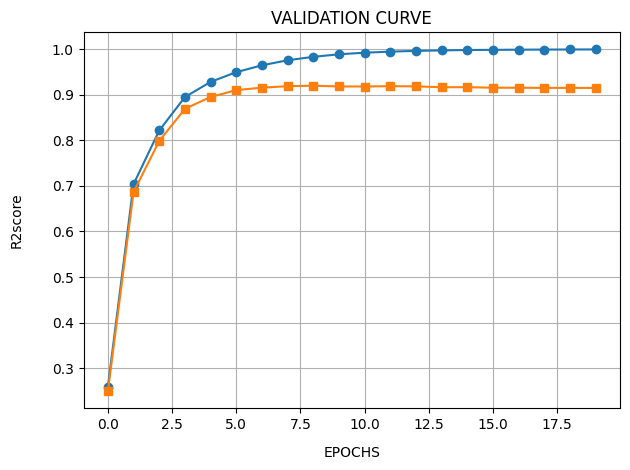

In [23]:
import matplotlib.pyplot as plt
plt.plot(trainmean,label='trainscore',marker='o')
plt.plot(valmean,label='valscore',marker='s')
plt.xlabel("EPOCHS",labelpad=10)
plt.ylabel("R2score",labelpad=20)
plt.title("VALIDATION CURVE")
plt.grid()
plt.tight_layout()
plt.show()

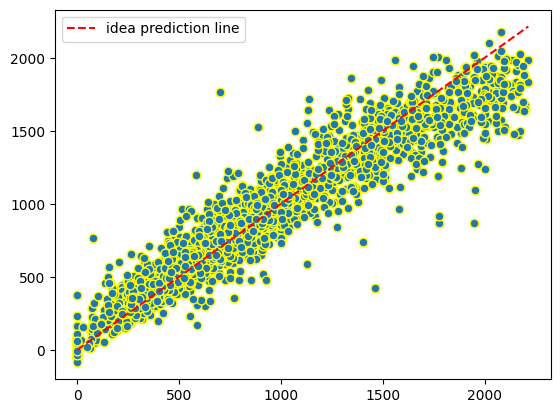

In [19]:
testpred=model.predict(xtest)
plt.scatter(ytest,testpred,s=40,edgecolors='Yellow')
ymin=ytest.min()
ymax=ytest.max()
plt.plot([ymin,ymax],[ymin,ymax],'r--',label='idea prediction line')
plt.legend()
plt.show()

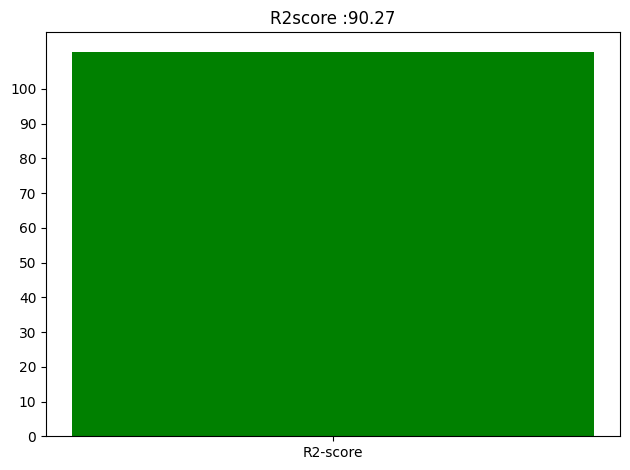

In [20]:
r2=r2_score(ytest,testpred)
mae=mean_absolute_error(ytest,testpred)
score=[mae,r2]
metrics=["R2-score"]
plt.bar(metrics,score,color='green')
plt.yticks(range(0,101,10))
plt.title(f"R2score :{r2*100:.2f}")
plt.tight_layout()
plt.show()


In [21]:
print(f"train r2score = {r2_score(ytrain,model.predict(xtrain))*100}")
print(f"test r2score = {r2_score(ytest,testpred)*100}")

train r2score = 92.60641416493054
test r2score = 90.27312839897476


In [22]:
import joblib 
joblib.dump(model,r"C:\Users\Avijit\Desktop\AgriAssure\AGRIYIELDPRO\MODEL\xgboost.pkl")

['C:\\Users\\Avijit\\Desktop\\AgriAssure\\AGRIYIELDPRO\\MODEL\\xgboost.pkl']